In [ ]:
import pandas as pd 
import numpy as np 
import torch
import torchvision
import torchvision.transforms as transforms
import json 
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow_io
import tensorflow_io as tfio

In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/SER- Project/VISTEC_src/misc/emotion_label.csv')
label_df.head()

,Unnamed: 0,filename,assigned_emo,majority_emo
0,0,s001_con_actor001_impro1_1.flac,Neutral,Neutral
1,1,s001_con_actor001_impro1_10.flac,Neutral,Neutral
2,2,s001_con_actor001_impro1_11.flac,Neutral,Neutral
3,3,s001_con_actor001_impro1_12.flac,Neutral,Neutral
4,4,s001_con_actor001_impro1_13.flac,Neutral,Neutral


In [ ]:


audio = tfio.audio.AudioIOTensor('/content/drive/MyDrive/SER- Project/VISTEC_src/studio001/middle/s001_middle_actor001_impro1_1.flac')
print(type(audio))
print(audio)
print(audio.shape)
print('*******\nslice')
from IPython.display import Audio
copy_audio = audio[:]
audio_slice = copy_audio[100: , 0:1] #bypass unknow error
print(type(audio_slice))
print(audio_slice)
print('>>>>>>>>>>>>>\n squeeze')

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])
#audio_tensor = audio_slice
print(audio_tensor)


Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

<class 'tensorflow_io.python.ops.audio_ops.AudioIOTensor'>
<AudioIOTensor: shape=[77616     2], dtype=<dtype: 'int16'>, rate=44100>
tf.Tensor([77616     2], shape=(2,), dtype=int64)
*******
slice
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[-290]
 [-281]
 [-262]
 ...
 [-393]
 [-393]
 [-421]], shape=(77516, 1), dtype=int16)
>>>>>>>>>>>>>
 squeeze
tf.Tensor([-290 -281 -262 ... -393 -393 -421], shape=(77516,), dtype=int16)


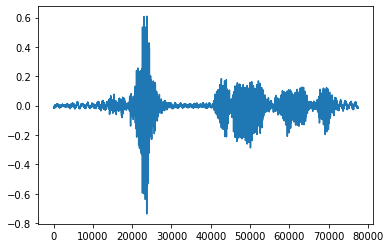

In [ ]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())


tf.Tensor([20741 69873], shape=(2,), dtype=int64)
tf.Tensor(20741, shape=(), dtype=int64) tf.Tensor(69873, shape=(), dtype=int64)


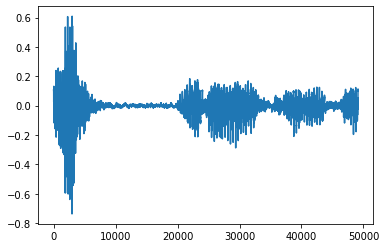

In [ ]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

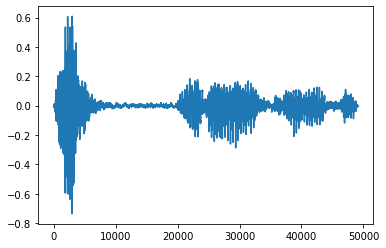

In [ ]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

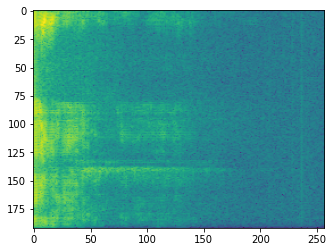

In [ ]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

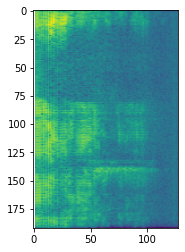

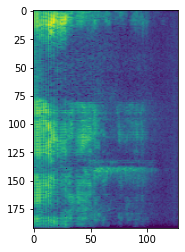

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [ ]:
print(dbscale_mel_spectrogram)

tf.Tensor(
[[-4.9690048e+01  6.2500305e+00 -3.9658151e+00 ... -4.2714653e+01
  -4.4199730e+01 -4.6943645e+01]
 [-4.9690048e+01  1.1740837e+01  1.5249920e+00 ... -3.7220695e+01
  -3.6628605e+01 -4.3051182e+01]
 [-4.9690048e+01  1.5892220e+01  5.6763749e+00 ... -3.3888008e+01
  -3.4151413e+01 -3.4601795e+01]
 ...
 [-4.9690048e+01  1.0829085e-02 -1.0205016e+01 ... -4.2436642e+01
  -4.2035069e+01 -4.5304878e+01]
 [-4.9690048e+01 -6.0924101e+00 -1.6308254e+01 ... -4.9690048e+01
  -4.9690048e+01 -4.9690048e+01]
 [-4.9690048e+01 -2.6830696e+01 -3.7046543e+01 ... -4.9690048e+01
  -4.9690048e+01 -4.9690048e+01]], shape=(192, 128), dtype=float32)


In [ ]:
print(dbscale_mel_spectrogram.shape)

(192, 128)


In [ ]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0 # [0,1]
    # img = (img - 0.5) * 2  # [0 -0.5 , 1 - 0.5] => [-0.5, 0.5] * 2 => [-1,1]
    return img


In [ ]:

import librosa
from tensorflow.keras.utils import load_img, img_to_array
import librosa.display
import os
import glob
# paths = glob.glob('/content/drive/MyDrive/SER- Project/VISTEC_src/studio001/middle/*')
# for path in paths: 
#   filename = os.path.basename(path) 
#   write_path = '/content/drive/MyDrive/SER- Project/spectogram/' + filename.replace('.flac','')
#   y, sr = librosa.load(path) # your file
#   S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
#   librosa.display.specshow(librosa.power_to_db(S, ref=np.max), fmax=8000)
#   plt.savefig(write_path, bbox_inches='tight', pad_inches=0) 
  

In [ ]:
print('Finish Write spectogram')

Finish Write spectogram


In [ ]:
read_paths = glob.glob('/content/drive/MyDrive/SER- Project/spectogram/*')
train_dataset = []
train_label = []
img_size = (256,256,3)
label_dict  =dict(zip(label_df.filename,label_df.majority_emo))
emotion_dict = {'Neutral' : 1, 'Angry' :2 , 'Happy':3 , 'Sad' : 4, 'Frustrated':5,'None' : 0}
for path in read_paths:
      filename = os.path.basename(path).replace('.png','.flac') 
      filename =filename.replace('middle','con')
      #print(filename)
      label = label_dict[filename]
      #"print(label)
      label  = emotion_dict[label]
      
      
      img = img_to_array(load_img(
        path,
        grayscale=False,
        color_mode='rgb',
        target_size=img_size,
        interpolation='bilinear'))
      img = prep_fn(img)
      train_dataset.append(img)
      train_label.append(label)

train_dataset = np.array(train_dataset)


    

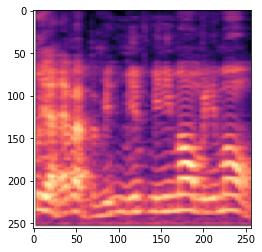

In [ ]:
img_train = (train_dataset * 255).astype('uint8') 
plt.imshow(img_train[1])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( train_dataset, train_label, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.93333334, 0.93333334, 0.9372549 ],
         ...,
         [0.19215687, 0.06666667, 0.39607844],
         [0.19215687, 0.06666667, 0.39607844],
         [0.19215687, 0.06666667, 0.39607844]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.93333334, 0.93333334, 0.9372549 ],
         ...,
         [0.13333334, 0.06666667, 0.30980393],
         [0.13333334, 0.06666667, 0.30980393],
         [0.13333334, 0.06666667, 0.30980393]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.93333334, 0.93333334, 0.9372549 ],
         ...,
         [0.11764706, 0.06666667, 0.28627452],
         [0.11764706, 0.06666667, 0.28627452],
         [0.11764706, 0.06666667, 0.28627452]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model.eval()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch 

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

AlexNet_model.features[0] = nn.

In [ ]:
train_data_torch = []
print(X_train.shape)
for i in range(len(X_train)):
   train_data_torch.append([X_train[i], y_train[i]])

trainloader = torch.utils.data.DataLoader(train_data_torch, shuffle=True, batch_size=100)
i1, l1 = next(iter(trainloader))
print(i1.shape)

(244, 256, 256, 3)
torch.Size([100, 256, 256, 3])


In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

RuntimeError: ignored